# **XAI Techniques in Supervised Learning** - Advanced Topics on Machine Learning (M.IA009) 2024/2025

**Group** : **DS1_GE**

> Cláudia Batista - up202108234

> João Gonçalves - up202107438

> Mafalda Aires - up202106550

The goal of this project is to explore the insights provided by different explainable artificial intelligence (XAI) techniques in a supervised learning context on tabular data.

#### **Table of Contents**
* [1. Pre-Modeling](#chapter1)
    * [Understanding the Data](#section_1_1)
    * [Dealing with Missing Data](#section_1_2)
* [2. White-Box Model](#chapter2)
    * [Encoding the Data](#section_2_1)
    * [Decision Tree](#section_2_2)
* [3. Black-Box Model](#chapter3)
    * [Simplification-Based Technique](#section_3_1)
    * [Feature-Based Techniques](#section_3_2)
    * [Example-Based Technique ](#section_3_3)

## **1. Pre-Modeling** <a class="anchor" id="chapter1"></a>

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from collections import defaultdict
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text
from sklearn.inspection import PartialDependenceDisplay
import lime
import lime.lime_tabular
import shap
import time
import dice_ml
from dice_ml import Dice
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import euclidean
from sklearn.inspection import permutation_importance

In [138]:
# Ignore all warnings
warnings.filterwarnings("ignore")

In [139]:
ds = pd.read_csv("portugal_listinigs.csv")

In [140]:
ds

,Price,District,City,Town,Type,EnergyCertificate,Floor,Parking,HasParking,ConstructionYear,...,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
0,250000.0,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,2nd Floor,1.0,True,NaN,...,True,NaN,2.0,NaN,NaN,NaN,114.0,NaN,NaN,2.0
1,9500.0,Faro,Albufeira,Albufeira e Olhos de Água,Apartment,NC,1st Floor,0.0,False,1990.0,...,True,NaN,0.0,NaN,NaN,NaN,27.0,NaN,NaN,1.0
2,580000.0,Faro,Vila do Bispo,Budens,Apartment,D,3rd Floor,1.0,True,2003.0,...,False,NaN,2.0,NaN,NaN,NaN,84.0,NaN,NaN,2.0
3,350000.0,Faro,Portimão,Portimão,Apartment,C,4th Floor,0.0,False,1985.0,...,True,NaN,2.0,NaN,NaN,NaN,68.0,NaN,NaN,1.0
4,175000.0,Faro,Faro,Faro (Sé e São Pedro),House,NC,NaN,0.0,False,1950.0,...,False,NaN,4.0,NaN,NaN,NaN,78.0,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120821,225000.0,Vila Real,Vila Real,Vila Real,Apartment,D,NaN,1.0,NaN,2003.0,...,False,False,NaN,3.0,0.0,NaN,108.0,NaN,129.0,2.0
120822,46500.0,Vila Real,Vila Real,Mouçós e Lamares,House,NC,NaN,0.0,NaN,1987.0,...,False,False,NaN,2.0,0.0,NaN,51.0,121.0,172.7,1.0
120823,80000.0,Vila Real,Valpaços,Carrazedo de Montenegro e Curros,House,F,NaN,0.0,NaN,1979.0,...,False,False,8.0,3.0,0.0,Reasonable,216.0,600.0,216.0,3.0
120824,12500.0,Vila Real,Peso da Régua,Moura Morta e Vinhós,House,NC,NaN,0.0,NaN,1974.0,...,False,False,NaN,2.0,0.0,NaN,28.0,38.0,62.0,1.0


### **Understanding the Data** <a class="anchor" id="section_1_1"></a>

#### General Information

In [141]:
ds.shape

(120826, 25)

In [142]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120826 entries, 0 to 120825
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Price                  120545 non-null  float64
 1   District               120826 non-null  object 
 2   City                   120826 non-null  object 
 3   Town                   120824 non-null  object 
 4   Type                   120810 non-null  object 
 5   EnergyCertificate      120812 non-null  object 
 6   Floor                  27929 non-null   object 
 7   Parking                120632 non-null  float64
 8   HasParking             68215 non-null   object 
 9   ConstructionYear       78228 non-null   float64
 10  TotalArea              113782 non-null  float64
 11  GrossArea              27638 non-null   float64
 12  EnergyEfficiencyLevel  52579 non-null   object 
 13  PublishDate            19224 non-null   object 
 14  Garage                 52579 non-nul

Let's change the 'PublishDate' column to datetime Dtype:

In [143]:
ds['PublishDate'] = pd.to_datetime(ds['PublishDate'])

In [144]:
categorical_columns = ds.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = ds.select_dtypes(include=['number']).columns.tolist()

#### Duplicates
Checking and removing the duplicates:

In [145]:
ds.duplicated().sum()

6941

In [146]:
ds.drop_duplicates()

,Price,District,City,Town,Type,EnergyCertificate,Floor,Parking,HasParking,ConstructionYear,...,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
0,250000.0,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,2nd Floor,1.0,True,NaN,...,True,NaN,2.0,NaN,NaN,NaN,114.0,NaN,NaN,2.0
1,9500.0,Faro,Albufeira,Albufeira e Olhos de Água,Apartment,NC,1st Floor,0.0,False,1990.0,...,True,NaN,0.0,NaN,NaN,NaN,27.0,NaN,NaN,1.0
2,580000.0,Faro,Vila do Bispo,Budens,Apartment,D,3rd Floor,1.0,True,2003.0,...,False,NaN,2.0,NaN,NaN,NaN,84.0,NaN,NaN,2.0
3,350000.0,Faro,Portimão,Portimão,Apartment,C,4th Floor,0.0,False,1985.0,...,True,NaN,2.0,NaN,NaN,NaN,68.0,NaN,NaN,1.0
4,175000.0,Faro,Faro,Faro (Sé e São Pedro),House,NC,NaN,0.0,False,1950.0,...,False,NaN,4.0,NaN,NaN,NaN,78.0,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120821,225000.0,Vila Real,Vila Real,Vila Real,Apartment,D,NaN,1.0,NaN,2003.0,...,False,False,NaN,3.0,0.0,NaN,108.0,NaN,129.0,2.0
120822,46500.0,Vila Real,Vila Real,Mouçós e Lamares,House,NC,NaN,0.0,NaN,1987.0,...,False,False,NaN,2.0,0.0,NaN,51.0,121.0,172.7,1.0
120823,80000.0,Vila Real,Valpaços,Carrazedo de Montenegro e Curros,House,F,NaN,0.0,NaN,1979.0,...,False,False,8.0,3.0,0.0,Reasonable,216.0,600.0,216.0,3.0
120824,12500.0,Vila Real,Peso da Régua,Moura Morta e Vinhós,House,NC,NaN,0.0,NaN,1974.0,...,False,False,NaN,2.0,0.0,NaN,28.0,38.0,62.0,1.0


#### Missing Values
Percentage of null values in each column:

In [147]:
ds.isnull().mean()*100

Price                     0.232566
District                  0.000000
City                      0.000000
Town                      0.001655
Type                      0.013242
EnergyCertificate         0.011587
Floor                    76.884942
Parking                   0.160561
HasParking               43.542781
ConstructionYear         35.255657
TotalArea                 5.829871
GrossArea                77.125784
EnergyEfficiencyLevel    56.483704
PublishDate              84.089517
Garage                   56.483704
Elevator                  0.026484
ElectricCarsCharging     56.483704
TotalRooms               43.884594
NumberOfBedrooms         70.678496
NumberOfWC               61.414762
ConservationStatus       87.550693
LivingArea               23.419628
LotSize                  73.441147
BuiltArea                82.638670
NumberOfBathrooms         4.742357
dtype: float64

There are a lot of missing values that need to be treated.

#### Statistic Summary

In [148]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,120545.0,367465.780519,4.024606e+06,1.0,79900.0,200000.0,392100.00,1.380000e+09
Parking,120632.0,0.570520,8.703738e-01,0.0,0.0,0.0,1.00,3.000000e+00
ConstructionYear,78228.0,1988.993596,2.669006e+01,1900.0,1972.0,1994.0,2008.00,2.024000e+03
TotalArea,113782.0,574281.432749,1.821361e+08,-7196067.0,94.0,171.0,580.00,6.142007e+10
GrossArea,27638.0,2789.732687,1.153670e+05,-7.0,100.0,164.0,294.00,1.275000e+07
TotalRooms,67802.0,3.151220,1.088089e+01,0.0,2.0,3.0,4.00,2.751000e+03
NumberOfBedrooms,35428.0,2.680253,1.863235e+00,0.0,2.0,3.0,3.00,2.100000e+01
NumberOfWC,46621.0,0.412196,1.021265e+00,-15.0,0.0,0.0,0.00,5.900000e+01
LivingArea,92529.0,1508.725924,3.684470e+04,0.0,80.0,120.0,212.00,5.429000e+06
LotSize,32090.0,67264.196447,5.784162e+06,0.0,288.0,756.5,3174.75,9.923010e+08


In [149]:
ds.describe(include=['object', 'category']).T

,count,unique,top,freq
District,120826,25,Lisboa,27588
City,120826,272,Lisboa,7422
Town,120824,2246,Albufeira e Olhos de Água,1370
Type,120810,21,Apartment,40218
EnergyCertificate,120812,12,NC,54872
Floor,27929,19,Ground Floor,6973
HasParking,68215,2,False,37370
EnergyEfficiencyLevel,52579,11,NC,24801
Garage,52579,2,False,43527
Elevator,120794,2,False,91452


- 'TotalArea', 'GrossArea' and 'BuiltArea' have negative values (check the corresponding min values). This doesn't make sense.
- 'NumberofBathrooms' and 'NumberofWC' also have negative values. This too doesn't make any sense.

We can see that in 'Price' (our target attribute) the min (1.0) and the max (1380000000.0) values are odd.

In [150]:
ds['Price'].nlargest(5)

58801     1.380000e+09
64294     3.600000e+07
82054     3.600000e+07
120664    2.500000e+07
64229     2.200000e+07
Name: Price, dtype: float64

In [151]:
ds.iloc[58801]

Price                             1380000000.0
District                                  Faro
City                                      Faro
Town                     Faro (Sé e São Pedro)
Type                                     House
EnergyCertificate                           NC
Floor                             Ground Floor
Parking                                    1.0
HasParking                                True
ConstructionYear                        1983.0
TotalArea                                536.0
GrossArea                                264.0
EnergyEfficiencyLevel                      NaN
PublishDate                                NaT
Garage                                     NaN
Elevator                                 False
ElectricCarsCharging                       NaN
TotalRooms                                 4.0
NumberOfBedrooms                           NaN
NumberOfWC                                 NaN
ConservationStatus                         NaN
LivingArea   

In [152]:
ds['Price'].nsmallest(5)

115016      1.0
76023     100.0
54126     250.0
25872     300.0
50950     300.0
Name: Price, dtype: float64

In [153]:
ds.iloc[115016]

Price                                           1.0
District                                       Faro
City                                          Loulé
Town                                      Quarteira
Type                                          House
EnergyCertificate                                 A
Floor                                           NaN
Parking                                         1.0
HasParking                                      NaN
ConstructionYear                                NaN
TotalArea                                     148.0
GrossArea                                       NaN
EnergyEfficiencyLevel                             A
PublishDate              2024-10-23 15:29:18.503000
Garage                                        False
Elevator                                      False
ElectricCarsCharging                          False
TotalRooms                                      4.0
NumberOfBedrooms                                3.0
NumberOfWC  

In [154]:
ds.drop(index=58801, inplace=True)

In [155]:
ds.drop(index=115016, inplace=True)

- We can see that max value for 'Price' is significantly bigger than the following biggest values. The instance that corresponds to that price value as a lot of nulls and some values that don't seem to make sense for that price point (total area of 538 and only 4 rooms?) . We remove that instance from our dataset. 
- The instance with price equal to 1.0 also doesn't make sense so we remove it from our data. 

### **Dealing with Missing Values** <a class="anchor" id="section_1_2"></a>

This dataset has a lot of columns with high percentages of missing values. Some of these missing values could be related with the type of property, for example, a land property is most likely not going to have a bathroom. Due to this high volatility of property types, each one with different important characteristics, we decided to only focus on apartments and houses.

In [156]:
df = ds[ds['Type'].isin(['Apartment', 'House'])]

In [157]:
df.head()

,Price,District,City,Town,Type,EnergyCertificate,Floor,Parking,HasParking,ConstructionYear,...,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
0,250000.0,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,2nd Floor,1.0,True,NaN,...,True,NaN,2.0,NaN,NaN,NaN,114.0,NaN,NaN,2.0
1,9500.0,Faro,Albufeira,Albufeira e Olhos de Água,Apartment,NC,1st Floor,0.0,False,1990.0,...,True,NaN,0.0,NaN,NaN,NaN,27.0,NaN,NaN,1.0
2,580000.0,Faro,Vila do Bispo,Budens,Apartment,D,3rd Floor,1.0,True,2003.0,...,False,NaN,2.0,NaN,NaN,NaN,84.0,NaN,NaN,2.0
3,350000.0,Faro,Portimão,Portimão,Apartment,C,4th Floor,0.0,False,1985.0,...,True,NaN,2.0,NaN,NaN,NaN,68.0,NaN,NaN,1.0
4,175000.0,Faro,Faro,Faro (Sé e São Pedro),House,NC,NaN,0.0,False,1950.0,...,False,NaN,4.0,NaN,NaN,NaN,78.0,NaN,NaN,2.0


In [158]:
df.shape

(73219, 25)

In [159]:
df.isnull().mean().round(2) * 100

Price                     0.0
District                  0.0
City                      0.0
Town                      0.0
Type                      0.0
EnergyCertificate         0.0
Floor                    66.0
Parking                   0.0
HasParking               42.0
ConstructionYear         14.0
TotalArea                 0.0
GrossArea                72.0
EnergyEfficiencyLevel    58.0
PublishDate              83.0
Garage                   58.0
Elevator                  0.0
ElectricCarsCharging     58.0
TotalRooms               21.0
NumberOfBedrooms         58.0
NumberOfWC               62.0
ConservationStatus       84.0
LivingArea                0.0
LotSize                  80.0
BuiltArea                79.0
NumberOfBathrooms         1.0
dtype: float64

The percentages of missing values in the filtered dataset are not that different from the percentages in the original dataset, but with only 2 types of properties is easier to treat them. 

We started by removing columns with more than 50% missing values:

In [160]:
threshold = 0.5  
df = df.loc[:, df.isnull().mean() < threshold]

In [161]:
df.head()

,Price,District,City,Town,Type,EnergyCertificate,Parking,HasParking,ConstructionYear,TotalArea,Elevator,TotalRooms,LivingArea,NumberOfBathrooms
0,250000.0,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,1.0,True,NaN,114.0,True,2.0,114.0,2.0
1,9500.0,Faro,Albufeira,Albufeira e Olhos de Água,Apartment,NC,0.0,False,1990.0,27.0,True,0.0,27.0,1.0
2,580000.0,Faro,Vila do Bispo,Budens,Apartment,D,1.0,True,2003.0,84.0,False,2.0,84.0,2.0
3,350000.0,Faro,Portimão,Portimão,Apartment,C,0.0,False,1985.0,68.0,True,2.0,68.0,1.0
4,175000.0,Faro,Faro,Faro (Sé e São Pedro),House,NC,0.0,False,1950.0,78.0,False,4.0,78.0,2.0


We suspect that 'HasParking' can be substitured by 'Parking', since if the value in 'Parking' is greater than 0.0 then 'HasParking' should always be True and vice-versa. Let's check that: 

In [162]:
violations = df[
    ((df['Parking'] > 0.0) & (df['HasParking'] == False)) | 
    ((df['HasParking'] == True) & (df['Parking'] <= 0)) 
]

print(f"Total number of violations: {len(violations)}")

Total number of violations: 0


The information in 'HasParking' can be found in 'Parking', let's remove 'HasParking':

In [163]:
df = df.drop(columns=['HasParking'])

In [164]:
df.isnull().sum()

Price                  209
District                 0
City                     0
Town                     0
Type                     0
EnergyCertificate        0
Parking                138
ConstructionYear     10394
TotalArea                9
Elevator                 9
TotalRooms           15140
LivingArea              14
NumberOfBathrooms      398
dtype: int64

Due to the relatively low number of lines with null values, we decided to remove the those lines:

In [165]:
df=df.dropna()

In [166]:
df.shape

(48690, 13)

In [167]:
df.head()

,Price,District,City,Town,Type,EnergyCertificate,Parking,ConstructionYear,TotalArea,Elevator,TotalRooms,LivingArea,NumberOfBathrooms
1,9500.0,Faro,Albufeira,Albufeira e Olhos de Água,Apartment,NC,0.0,1990.0,27.0,True,0.0,27.0,1.0
2,580000.0,Faro,Vila do Bispo,Budens,Apartment,D,1.0,2003.0,84.0,False,2.0,84.0,2.0
3,350000.0,Faro,Portimão,Portimão,Apartment,C,0.0,1985.0,68.0,True,2.0,68.0,1.0
4,175000.0,Faro,Faro,Faro (Sé e São Pedro),House,NC,0.0,1950.0,78.0,False,4.0,78.0,2.0
5,1485000.0,Faro,Loulé,Quarteira,House,D,2.0,2004.0,472.0,False,4.0,414.0,5.0


As seen before, 'EnergyCertificate' attribute has 2 different categories that could be one. 'NC' = 'No Certificate':

In [168]:
df['EnergyCertificate'].unique()

array(['NC', 'D', 'C', 'A', 'B-', 'B', 'E', 'A+', 'F', 'G',
       'No Certificate'], dtype=object)

Let's change that:

In [169]:
df['EnergyCertificate'] = df['EnergyCertificate'].replace({'No Certificate': 'NC'})

In [170]:
df['EnergyCertificate'].unique()

array(['NC', 'D', 'C', 'A', 'B-', 'B', 'E', 'A+', 'F', 'G'], dtype=object)

#### **Data Analysis**

In [171]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,48690.0,375907.844686,494558.920456,600.0,157000.0,249900.0,420000.0,16800000.0
Parking,48690.0,0.846190,0.979625,0.0,0.0,1.0,1.0,3.0
ConstructionYear,48690.0,1989.482522,26.305389,1900.0,1973.0,1994.0,2009.0,2024.0
TotalArea,48690.0,4935.160608,426140.495386,-271.0,86.0,133.0,276.0,56215100.0
TotalRooms,48690.0,3.336681,12.601584,0.0,2.0,3.0,4.0,2751.0
LivingArea,48690.0,229.478127,4316.954361,0.0,75.0,108.0,166.0,470300.0
NumberOfBathrooms,48690.0,2.027891,1.366335,-1.0,1.0,2.0,3.0,24.0


In [172]:
df.describe(include=['object', 'category']).T

,count,unique,top,freq
District,48690,23,Lisboa,14375
City,48690,267,Lisboa,4310
Town,48690,2072,Cascais e Estoril,887
Type,48690,2,Apartment,25374
EnergyCertificate,48690,10,D,9653
Elevator,48690,2,False,33002


There are still numerical features with negative values that don't make sense ('TotalArea' and 'NumberofBathrooms'). Let's module those columns:

In [173]:
df['TotalArea'] = df['TotalArea'].abs()
df['NumberOfBathrooms'] = df['NumberOfBathrooms'].abs()

In [174]:
categorical_columns=['Type', 'EnergyCertificate', 'District']

##### **Univariate Analysis**

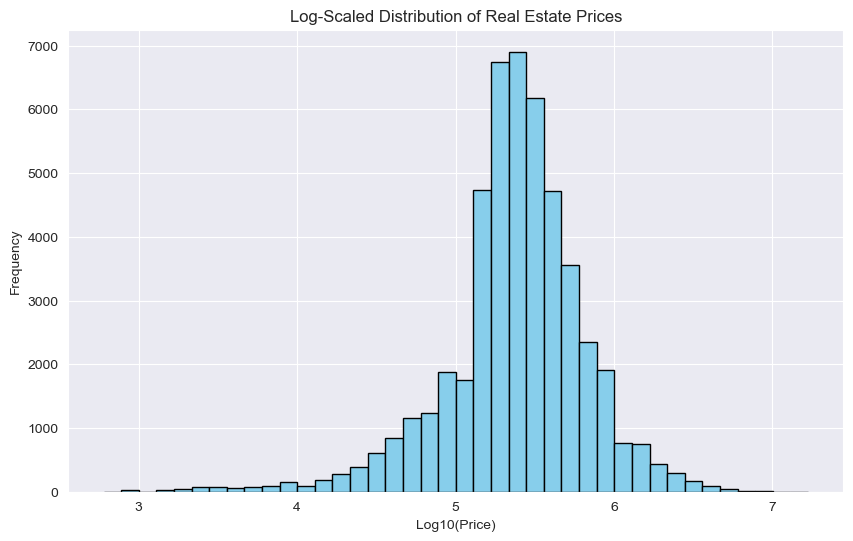

In [175]:
np.log10(df['Price']).plot(kind='hist', bins=40, figsize=(10, 6), edgecolor='black', color='skyblue')

plt.xlabel('Log10(Price)')
plt.ylabel('Frequency')
plt.title('Log-Scaled Distribution of Real Estate Prices')
plt.show()

In [176]:
def plot_count_columns(dataset, columns, figsize=(8, 5), color='lightgreen', edgecolor='black', rotation=45, plots_per_row=3):
    num_columns = len(columns)
    rows = math.ceil(num_columns / plots_per_row)  # Calculate the number of rows
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(figsize[0], figsize[1] * rows))
    
    # Flatten axes to simplify indexing (handles 1D or 2D axes arrays)
    axes = axes.flatten()
    
    for i, column in enumerate(columns):
        sns.countplot(ax=axes[i], x=column, data=dataset, color=color, edgecolor=edgecolor)
        axes[i].set_title(f'Count of {column} per Property')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=rotation)
    
    # Hide any unused subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

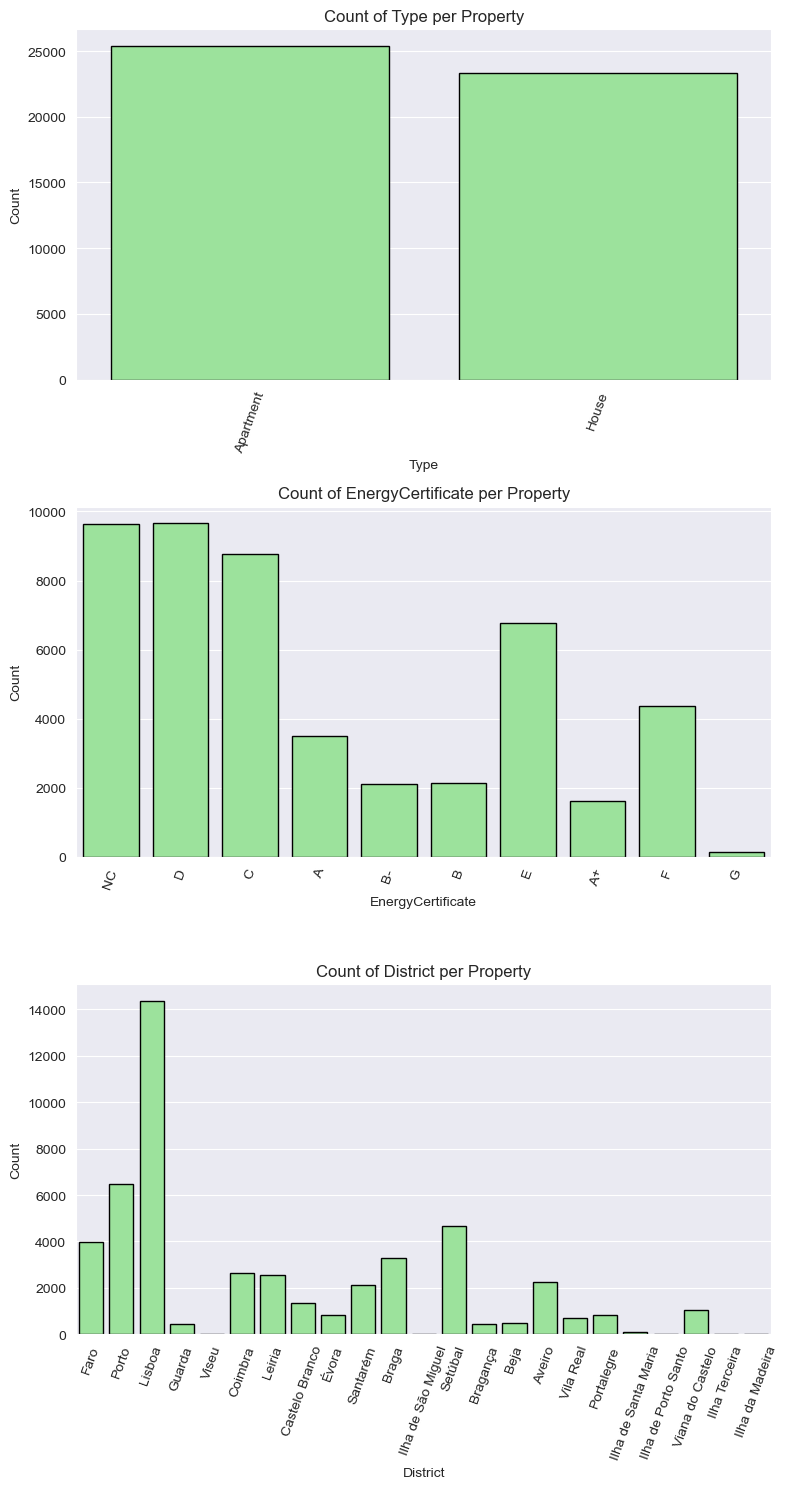

In [177]:
plot_count_columns(dataset=df, columns=categorical_columns, rotation=70, plots_per_row=1)

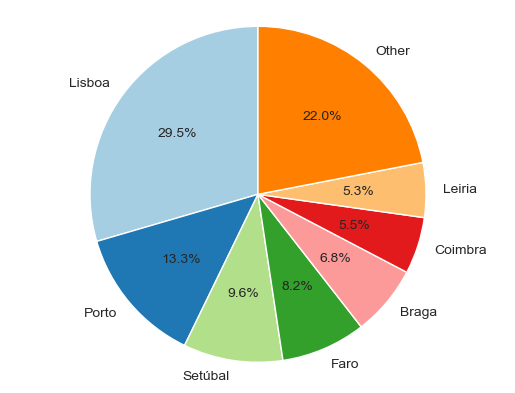

In [178]:
district_counts = df['District'].value_counts()
total_count = district_counts.sum()
district_percentages = (district_counts / total_count) * 100

district_main = district_counts[district_percentages >= 5]
district_other = district_counts[district_percentages < 5].sum()

district_counts_final = pd.concat([district_main, pd.Series({'Other': district_other})])

fig, ax = plt.subplots()
ax.pie(district_counts_final.values, labels=district_counts_final.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

plt.axis('equal')
plt.show()

##### **Bivariate Analysis**

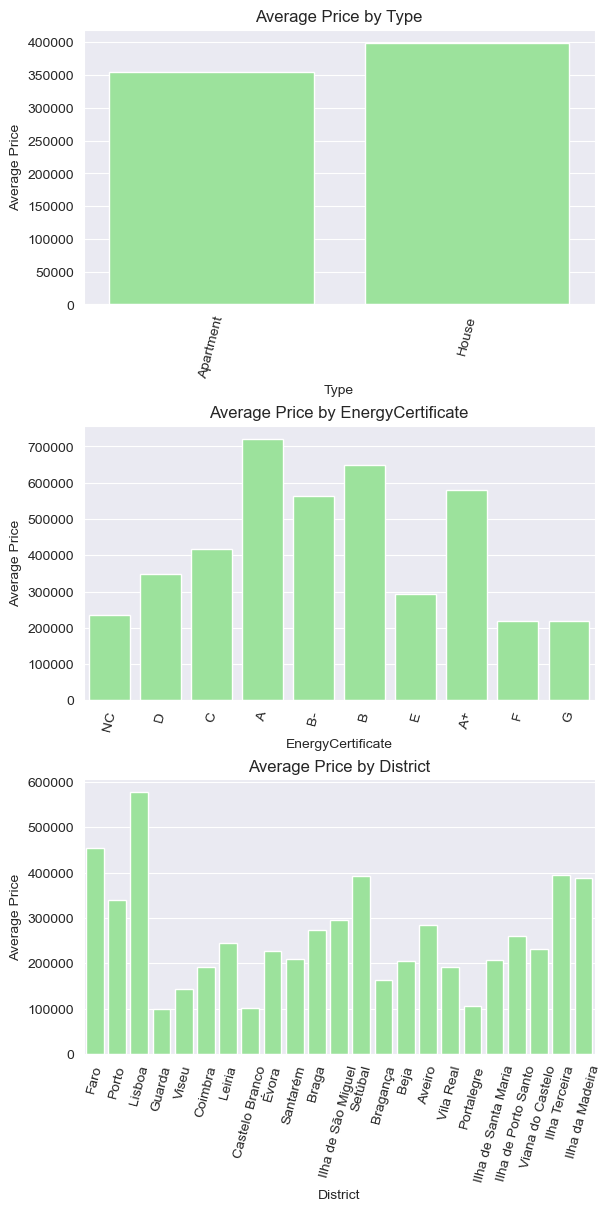

In [179]:
num_columns = len(categorical_columns)
fig, axes = plt.subplots(num_columns, 1, figsize=(6, 12), constrained_layout=True)

for i, col in enumerate(categorical_columns):
    sns.barplot(ax=axes[i], x=col, y='Price', data=df, estimator='mean', errorbar=None, color='lightgreen')
    axes[i].set_title(f'Average Price by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Average Price')
    axes[i].tick_params(axis='x', rotation=75)

plt.show()

In [180]:
df.groupby('Type')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
Apartment,25374.0,354541.242996,347973.189290,600.0,180000.0,250000.0,395000.0,5950000.0
House,23316.0,399160.381626,614789.553854,2400.0,98000.0,240000.0,450000.0,16800000.0


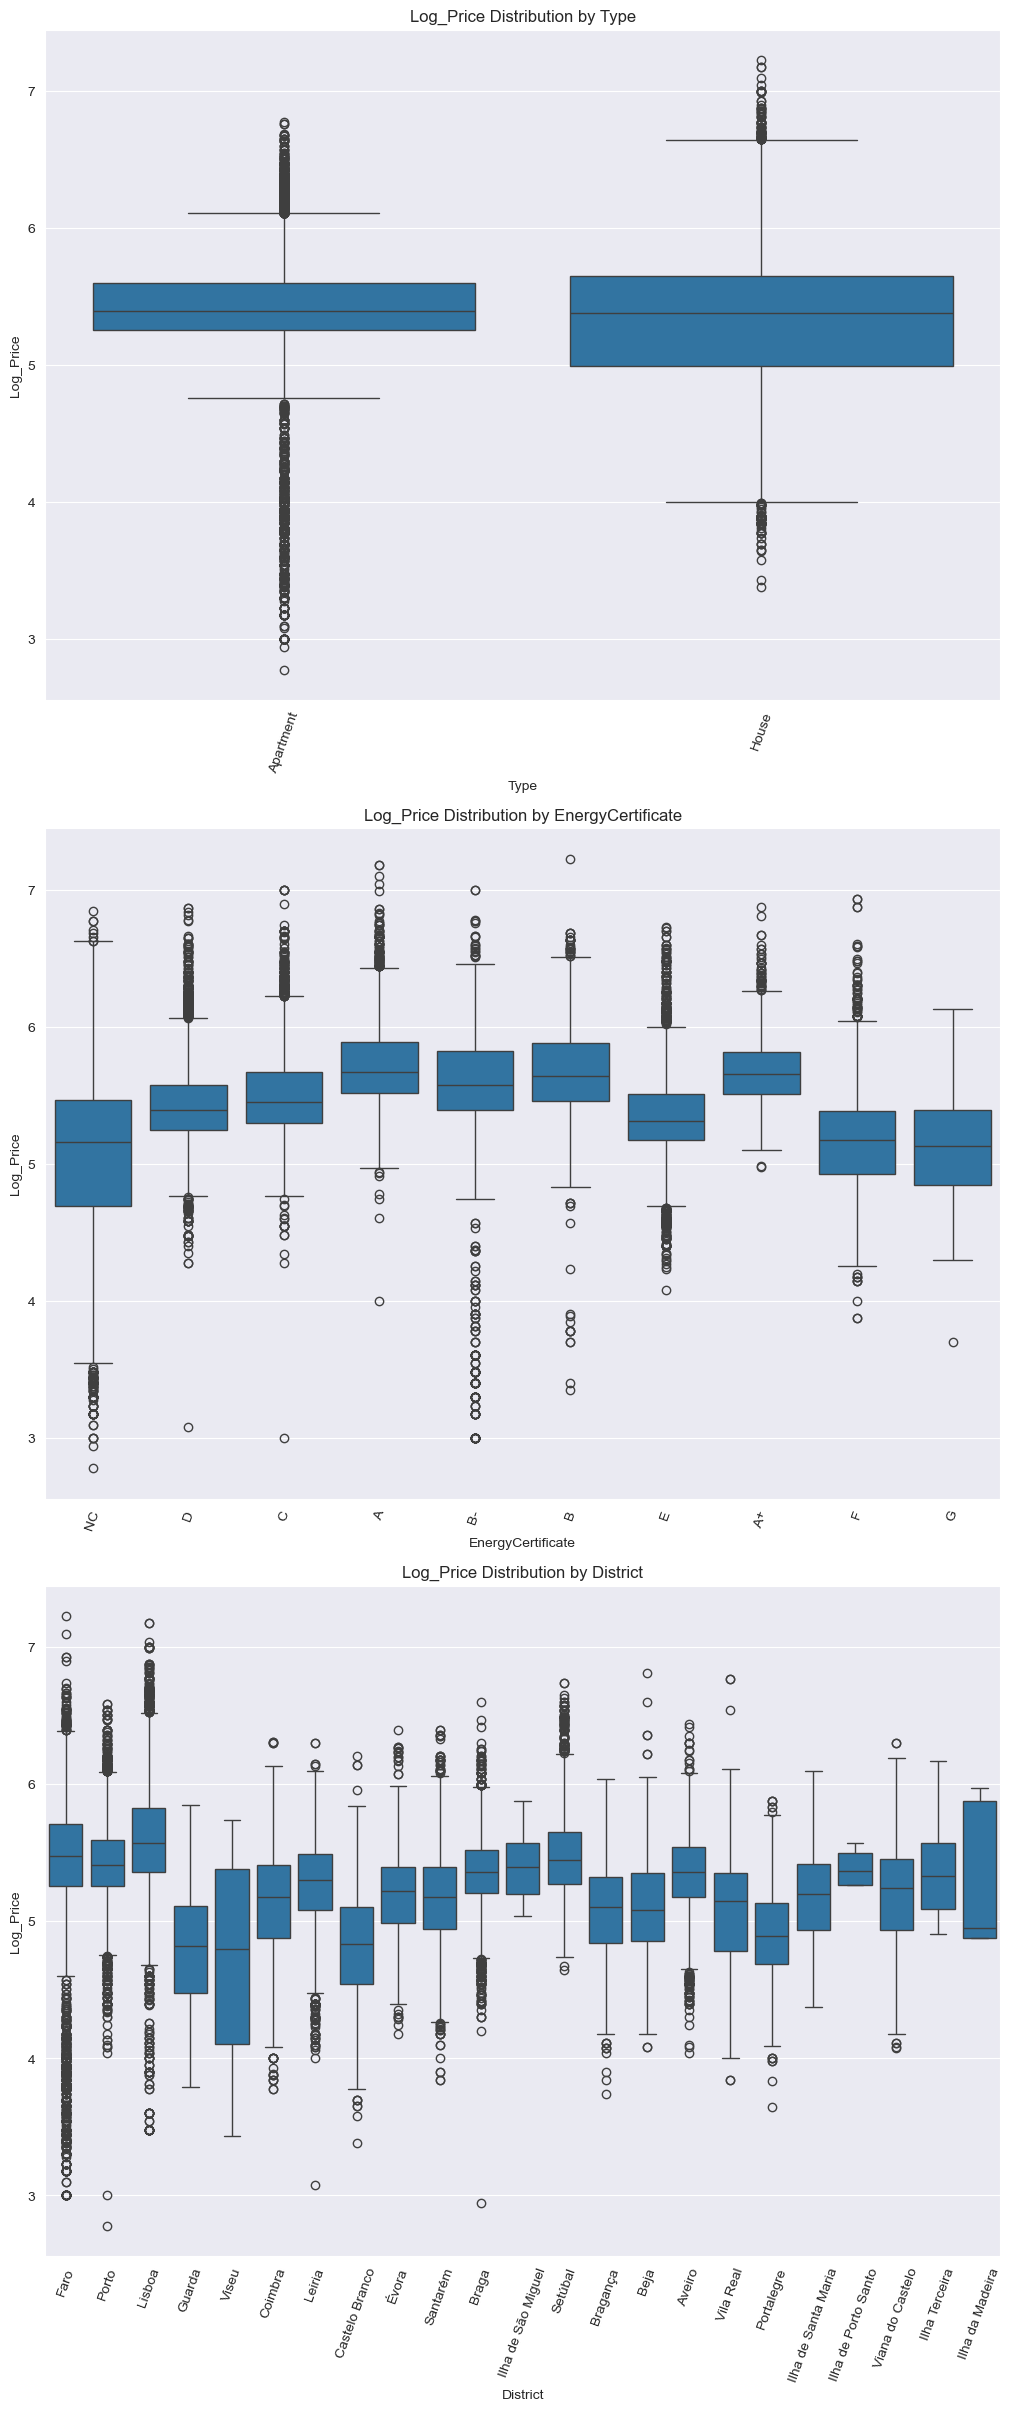

In [181]:
def plot_categorical_vs_price(dataset, categorical_columns, target_column='Log_Price', figsize=(10, 8), plots_per_row=1):
    num_columns = len(categorical_columns)
    rows = math.ceil(num_columns / plots_per_row)
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(figsize[0], figsize[1] * rows), constrained_layout=True)
    
    axes = axes.flatten()
    
    for i, col in enumerate(categorical_columns):
        sns.boxplot(data=dataset, x=col, y=target_column, ax=axes[i])
        axes[i].set_title(f'{target_column} Distribution by {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(target_column)
        axes[i].tick_params(axis='x', rotation=70)
    
    
    for j in range(len(categorical_columns), len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

df['Log_Price'] = np.log10(df['Price'])
plot_categorical_vs_price(df, categorical_columns, target_column='Log_Price', plots_per_row=1)
df.drop('Log_Price', axis=1, inplace=True)

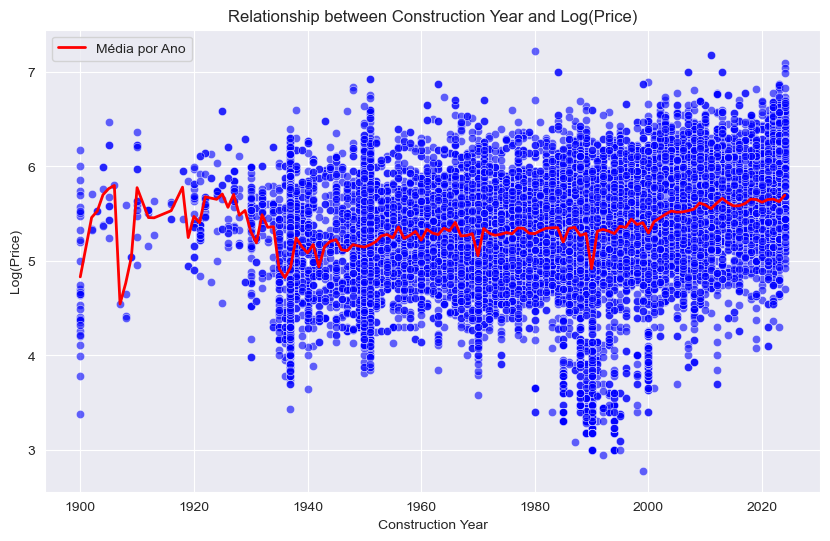

In [182]:
df['Log_Price'] = np.log10(df['Price'])

mean_log_price_per_year = df.groupby('ConstructionYear')['Log_Price'].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='ConstructionYear', y='Log_Price', data=df, color='blue', alpha=0.6)

plt.plot(mean_log_price_per_year.index, mean_log_price_per_year.values, color='red', label='Média por Ano', linewidth=2)

plt.title('Relationship between Construction Year and Log(Price)')
plt.xlabel('Construction Year')
plt.ylabel('Log(Price)')

plt.legend()
plt.show()

df.drop('Log_Price', axis=1, inplace=True)

##### **Correlation Maps**

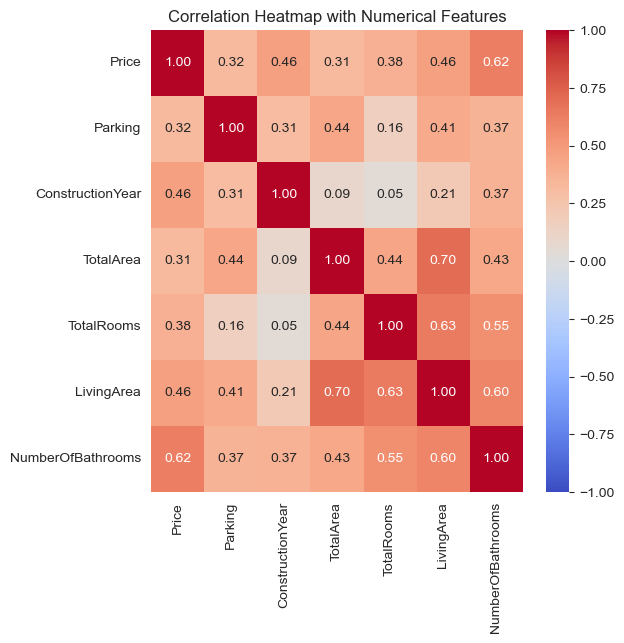

In [183]:
corr_matrix2 = df[['Price', 'Parking', 'ConstructionYear', 'TotalArea', 'TotalRooms', 'LivingArea', 'NumberOfBathrooms']].corr(method='spearman') 

plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap with Numerical Features')
plt.show()

- 'LivingArea' is highly correlated to 'TotalArea', should one of them be removed?
- Also, 'LivingArea' has high correlation with 'NumberOfBathrooms' and 'TotalRooms'.

## **2. White-Box Model**

### **Encoding the Data** <a class="anchor" id="section_2_1"></a>

We need to encode the following categorical columns: 'District', 'City', 'Town', 'Type' and 'EnergyCertificate'.

In [184]:
df.head()

,Price,District,City,Town,Type,EnergyCertificate,Parking,ConstructionYear,TotalArea,Elevator,TotalRooms,LivingArea,NumberOfBathrooms
1,9500.0,Faro,Albufeira,Albufeira e Olhos de Água,Apartment,NC,0.0,1990.0,27.0,True,0.0,27.0,1.0
2,580000.0,Faro,Vila do Bispo,Budens,Apartment,D,1.0,2003.0,84.0,False,2.0,84.0,2.0
3,350000.0,Faro,Portimão,Portimão,Apartment,C,0.0,1985.0,68.0,True,2.0,68.0,1.0
4,175000.0,Faro,Faro,Faro (Sé e São Pedro),House,NC,0.0,1950.0,78.0,False,4.0,78.0,2.0
5,1485000.0,Faro,Loulé,Quarteira,House,D,2.0,2004.0,472.0,False,4.0,414.0,5.0


In [185]:
df_raw = df.copy()

##### Modifying 'District', 'City' and 'Town'

In [186]:
y = df['Price']
X = df.drop(columns=['Price'])

target_encoder = TargetEncoder(return_df=True, cols=['District', 'City', 'Town'])
df = target_encoder.fit_transform(X, y)

#Re-attach the price column
df.insert(0, 'Price', y)

The features 'District', 'City' and 'Town' were target encoded because they have a multiple categories. But this type of encoding can lead to overfitting and is not easy to interpret. Can we divide the categories in those columns into more general categories?

In [187]:
df[['District', 'City', 'Town']].describe().T

,count,mean,std,min,25%,50%,75%,max
District,48690.0,375974.750700,153945.362904,98353.792411,244783.579625,340154.640371,576502.203304,5.765022e+05
City,48690.0,378775.615166,221369.315332,53920.352198,234452.234957,326488.016177,424096.092896,1.118079e+06
Town,48690.0,406714.143825,242320.747169,62675.601051,270596.521819,334919.062308,438833.422676,1.554002e+06


In [188]:
dis_dic = dict(zip(df_raw['District'], df['District']))
city_dic = dict(zip(df_raw['City'], df['City']))
town_dic = dict(zip(df_raw['Town'], df['Town']))

In [189]:
print(dis_dic)

{'Faro': 453553.8449823766, 'Porto': 340154.6403712297, 'Lisboa': 576502.2033043478, 'Guarda': 98353.79241071429, 'Viseu': 282460.3722750587, 'Coimbra': 192897.81848928976, 'Leiria': 244783.57962529274, 'Castelo Branco': 102277.28982300885, 'Évora': 226201.90436835893, 'Santarém': 210486.0760206476, 'Braga': 273849.0399636694, 'Ilha de São Miguel': 329327.2893442009, 'Setúbal': 393271.7513942514, 'Bragança': 163693.77358490566, 'Beja': 204531.94560669456, 'Aveiro': 284000.6012461059, 'Vila Real': 192039.04922644162, 'Portalegre': 106424.55907429963, 'Ilha de Santa Maria': 206930.10016468403, 'Ilha de Porto Santo': 356437.4577601474, 'Viana do Castelo': 232417.12135465664, 'Ilha Terceira': 380037.86145028897, 'Ilha da Madeira': 377931.3369294433}


Our goal is to group districts, cities, and towns into price ranges of 100,000 and assign a category to each range. Let's explore how we can achieve this by examining how each column is categorized into these price classes:

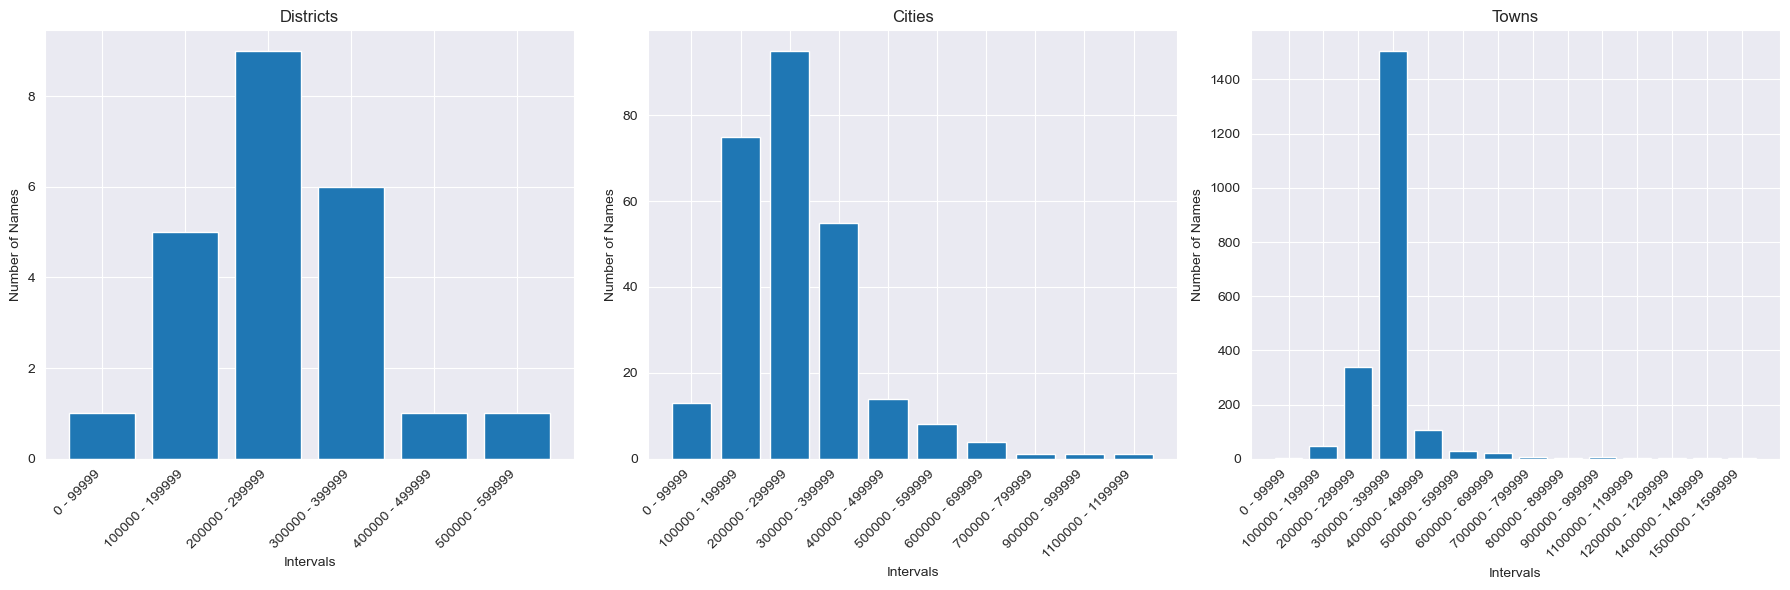

In [190]:
def count_names_by_interval(my_dict, ax, title):
    class_size = 100000
    groups = defaultdict(list)
    
    for name, value in my_dict.items():
        class_start = (value // class_size) * class_size
        class_start = int(class_start)
        
        groups[f"{class_start} - {class_start + class_size - 1}"].append(name)
    
    intervals = []
    num_names = []
    
    for interval in sorted(groups.keys(), key=lambda x: int(x.split(" - ")[0])):
        names_in_interval = groups[interval]
        intervals.append(interval)
        num_names.append(len(names_in_interval))

    ax.bar(intervals, num_names)
    ax.set_xticklabels(intervals, rotation=45, ha='right')
    ax.set_xlabel('Intervals')
    ax.set_ylabel('Number of Names')
    ax.set_title(title)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
count_names_by_interval(dis_dic, axes[0], "Districts")
count_names_by_interval(city_dic, axes[1], "Cities")
count_names_by_interval(town_dic, axes[2], "Towns")
fig.tight_layout()
plt.show()

**Strategy**: Categorize the districts, cities, and towns based on their mean price into the following price ranges:
- 6: "Very High Price" (700000 - 1599999)
- 5: "High Price" (500000 - 699999)
- 4: "Upper-Mid Price" (400000 - 499999)
- 3: "Mid Price" (300000 - 399999)
- 2: "Lower-Mid Price" (200000 - 299999)
- 1: "Low Price" (100000 - 199999)
- 0: "Very Low Price"  (0 - 99999)

In [191]:
def categorize_price(price):
    if price >= 700000:
        return "Very High Price"
    elif price >= 500000:
        return "High Price"
    elif price >= 400000:
        return "Upper-Mid Price"
    elif price >= 300000:
        return "Mid Price"
    elif price >= 200000:
        return "Lower-Mid Price"
    elif price >= 100000:
        return "Low Price"
    else:
        return "Very Low Price"

In [192]:
df['District'] = df['District'].apply(categorize_price)
df['City'] = df['City'].apply(categorize_price)
df['Town'] = df['Town'].apply(categorize_price)

In [193]:
df.head()

,Price,District,City,Town,Type,EnergyCertificate,Parking,ConstructionYear,TotalArea,Elevator,TotalRooms,LivingArea,NumberOfBathrooms
1,9500.0,Upper-Mid Price,Lower-Mid Price,Lower-Mid Price,Apartment,NC,0.0,1990.0,27.0,True,0.0,27.0,1.0
2,580000.0,Upper-Mid Price,High Price,Upper-Mid Price,Apartment,D,1.0,2003.0,84.0,False,2.0,84.0,2.0
3,350000.0,Upper-Mid Price,Upper-Mid Price,Mid Price,Apartment,C,0.0,1985.0,68.0,True,2.0,68.0,1.0
4,175000.0,Upper-Mid Price,High Price,Upper-Mid Price,House,NC,0.0,1950.0,78.0,False,4.0,78.0,2.0
5,1485000.0,Upper-Mid Price,High Price,High Price,House,D,2.0,2004.0,472.0,False,4.0,414.0,5.0


##### Encoding the data

In [194]:
energy_certificate_categories = [['NC', 'G', 'F', 'E', 'D', 'C', 'B-', 'B', 'A', 'A+']]
price_categories = [["Very Low Price", "Low Price", "Lower-Mid Price", "Mid Price",
                     "Upper-Mid Price", "High Price", "Very High Price"]]

preprocessor = ColumnTransformer(
    transformers=[
        # Ordinal Encoding
        ('energy_certificate', OrdinalEncoder(categories=energy_certificate_categories), ['EnergyCertificate']),
        ('district', OrdinalEncoder(categories=price_categories), ['District']),
        ('city', OrdinalEncoder(categories=price_categories), ['City']),
        ('town', OrdinalEncoder(categories=price_categories), ['Town']),
        
        # One-Hot Encoding for "Type"
        ('type_onehot', OneHotEncoder(drop=None, dtype=int), ['Type']),
        
        # Binary Mapping for "Elevator"
        ('elevator_map', FunctionTransformer(lambda x: x['Elevator'].map({True: 1, False: 0}).to_numpy().reshape(-1, 1)), ['Elevator']),
    ],
    remainder='passthrough',  # Keep other columns if needed
    force_int_remainder_cols=False  # New behavior for remainder column naming
)

In [195]:
def transform_with_column_names(column_transformer, df):
    """Apply a ColumnTransformer and return a pandas DataFrame with column names."""
    transformed_data = column_transformer.fit_transform(df)
    column_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            column_names.extend(transformer.get_feature_names_out(columns))
        else:
            column_names.extend(columns)
    return pd.DataFrame(transformed_data, columns=column_names)

In [196]:
encoded_df = transform_with_column_names(preprocessor, df)
encoded_df.head()

,EnergyCertificate,District,City,Town,Type_Apartment,Type_House,Elevator,Price,Parking,ConstructionYear,TotalArea,TotalRooms,LivingArea,NumberOfBathrooms
0,0.0,4.0,2.0,2.0,1.0,0.0,1.0,9500.0,0.0,1990.0,27.0,0.0,27.0,1.0
1,4.0,4.0,5.0,4.0,1.0,0.0,0.0,580000.0,1.0,2003.0,84.0,2.0,84.0,2.0
2,5.0,4.0,4.0,3.0,1.0,0.0,1.0,350000.0,0.0,1985.0,68.0,2.0,68.0,1.0
3,0.0,4.0,5.0,4.0,0.0,1.0,0.0,175000.0,0.0,1950.0,78.0,4.0,78.0,2.0
4,4.0,4.0,5.0,5.0,0.0,1.0,0.0,1485000.0,2.0,2004.0,472.0,4.0,414.0,5.0


### **Decision Tree** <a class="anchor" id="section_2_2"></a>

In [197]:
y = encoded_df['Price']
X = encoded_df.drop(columns=['Price'])

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [199]:
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train,y_train)

DecisionTreeRegressor(random_state=0)

In [200]:
y_pred = dt.predict(X_test)

In [201]:
mae = mean_absolute_error(y_test, y_pred)
print("Erro Absoluto Médio (MAE):", mae)

mse = mean_squared_error(y_test, y_pred)
print("Erro Quadrático Médio (MSE):", mse)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

Erro Absoluto Médio (MAE): 110305.95866212242
Erro Quadrático Médio (MSE): 106801316657.34671
R2 Score: 0.5898881507668486


The White-Box model has an average error of approximately 110,000 euros in predicting house/apartment prices.

With an R² value of 0.59, the model explains approximately 59% of the variance in the data.

In [202]:
feature_importances = pd.Series(dt.feature_importances_, index=X.columns)

feature_importances

EnergyCertificate    0.038075
District             0.042193
City                 0.037556
Town                 0.238997
Type_Apartment       0.002641
Type_House           0.003087
Elevator             0.005864
Parking              0.008679
ConstructionYear     0.061351
TotalArea            0.065614
TotalRooms           0.028810
LivingArea           0.229679
NumberOfBathrooms    0.237454
dtype: float64

In [203]:
feature_names = X.columns

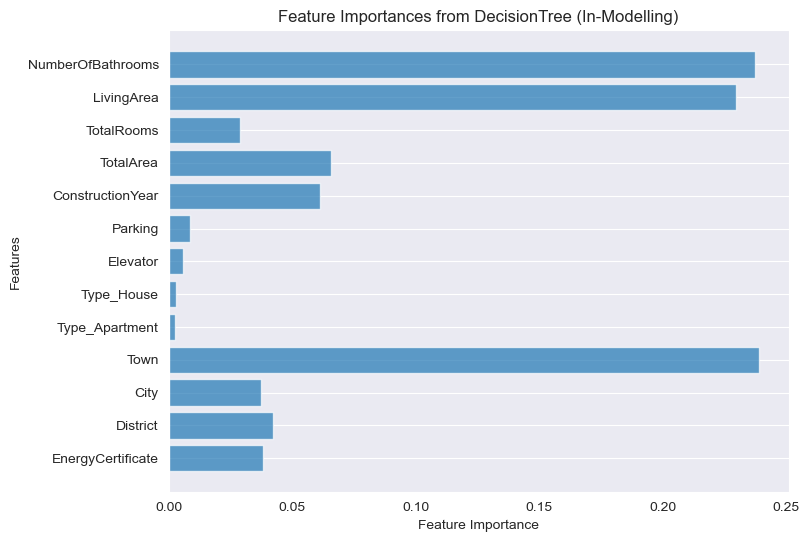

In [204]:
plt.figure(figsize=(8,6))
plt.barh(feature_names, dt.feature_importances_, align='center', alpha=0.7)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from DecisionTree (In-Modelling)")
plt.grid(axis="x")
plt.show()

## **3. Black-Box Model**

In [205]:
y = encoded_df['Price']
X = encoded_df.drop(columns=['Price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [206]:
black_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
black_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, random_state=42)

In [207]:
y_pred_rf = black_model.predict(X_test)

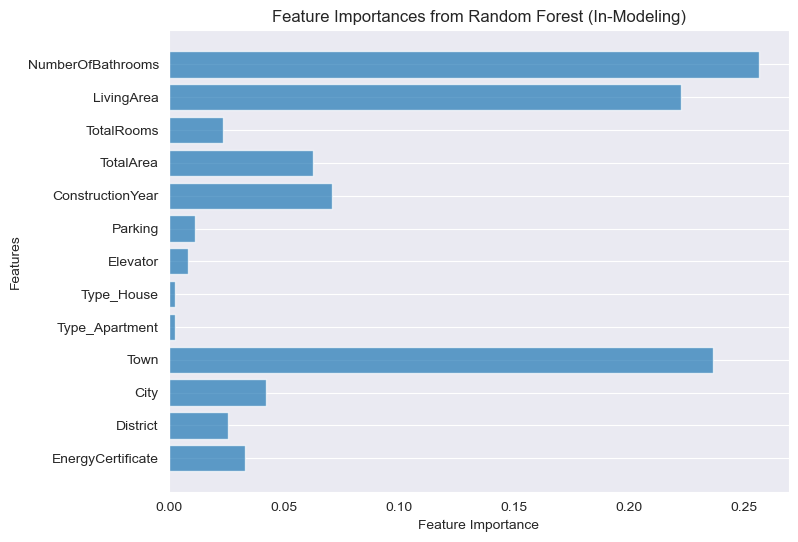

In [208]:
plt.figure(figsize=(8,6))
plt.barh(feature_names, black_model.feature_importances_, align='center', alpha=0.7)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from Random Forest (In-Modeling)")
plt.grid(axis="x")
plt.show()

### **Simplification-Based Technique** <a class="anchor" id="section_3_1"></a>

#### **Global Surrogates**

- Train a decision tree (an interpretable model) to approximate the predictions of the random forest, so it can be more interpretable.

In [209]:
# Training the surrogate model on X_train using black box model predictions
surrogate_model = DecisionTreeRegressor(max_depth=5, random_state=42)
surrogate_model.fit(X_train, black_model.predict(X_train))

DecisionTreeRegressor(max_depth=5, random_state=42)

##### **Model Evaluation**

In [210]:
# Assessment of how well the surrogate model fits the predictions of the black box model
surrogate_predictions = surrogate_model.predict(X_test)
r2_sm = r2_score(y_pred_rf, surrogate_predictions)

print(f"R^2 Score of Surrogate Tree: {r2_sm}")

R^2 Score of Surrogate Tree: 0.8104894585207797


The R² value = 0.81 indicates that the surrogate model (decision tree) is able to explain 81% of the variability of the predictions made by the black-box model.

This is a good result, showing that:
   - The surrogate model is capturing the logic of the black-box model effectively.
   - The surrogate provides a simplified explanation of the original model's decisions, while maintaining a good approximation.

##### **Prediction Comparison**

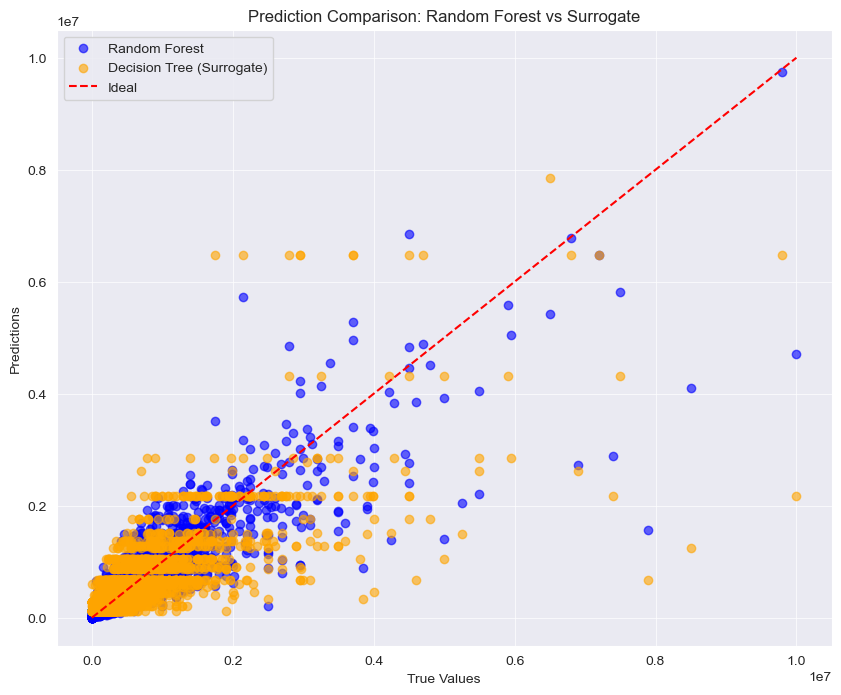

In [211]:
# Prediction Comparison
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_rf, alpha=0.6, label='Random Forest', color='blue')
plt.scatter(y_test, surrogate_predictions, alpha=0.6, label='Decision Tree (Surrogate)', color='orange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction Comparison: Random Forest vs Surrogate')
plt.legend()
plt.grid(alpha=0.7)
plt.show()

Surrogate's strengths:
- The Decision Tree surrogate model captures the behavior of the Random Forest well for low and simple values.
- It provides a more interpretable explanation of the original model.

Surrogate's limitations:
- Surrogate oversimplifies Random Forest predictions, especially for high values, where the original model is more accurate.
- This reflects the limitations of decision trees in capturing complex, non-linear patterns present in the black-box model.

##### **Feature Importance Black Model**
###### Used for comparison with surrogate model

In [212]:
# Importância das features do modelo original (black-box)
blackbox_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": black_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance do Modelo Black-Box:")
print(blackbox_importance)


Feature Importance do Modelo Black-Box:
              Feature  Importance
12  NumberOfBathrooms    0.256634
3                Town    0.236675
11         LivingArea    0.222878
8    ConstructionYear    0.070938
9           TotalArea    0.062704
2                City    0.042378
0   EnergyCertificate    0.033057
1            District    0.025761
10         TotalRooms    0.023539
7             Parking    0.011722
6            Elevator    0.008478
5          Type_House    0.002636
4      Type_Apartment    0.002599


##### **Decision Tree Rules**

In [213]:
tree_rules = export_text(surrogate_model, feature_names=list(X.columns))
print(tree_rules)

|--- NumberOfBathrooms <= 3.50
|   |--- Town <= 4.50
|   |   |--- NumberOfBathrooms <= 2.50
|   |   |   |--- City <= 2.50
|   |   |   |   |--- NumberOfBathrooms <= 1.50
|   |   |   |   |   |--- value: [112757.54]
|   |   |   |   |--- NumberOfBathrooms >  1.50
|   |   |   |   |   |--- value: [202267.86]
|   |   |   |--- City >  2.50
|   |   |   |   |--- LivingArea <= 102.50
|   |   |   |   |   |--- value: [227111.52]
|   |   |   |   |--- LivingArea >  102.50
|   |   |   |   |   |--- value: [337559.54]
|   |   |--- NumberOfBathrooms >  2.50
|   |   |   |--- City <= 2.50
|   |   |   |   |--- District <= 3.50
|   |   |   |   |   |--- value: [302276.50]
|   |   |   |   |--- District >  3.50
|   |   |   |   |   |--- value: [457863.38]
|   |   |   |--- City >  2.50
|   |   |   |   |--- LivingArea <= 184.50
|   |   |   |   |   |--- value: [437591.72]
|   |   |   |   |--- LivingArea >  184.50
|   |   |   |   |   |--- value: [545405.58]
|   |--- Town >  4.50
|   |   |--- LivingArea <= 123.50
|  

Frequent features:
- NumberOfBathrooms is the most used feature in main splits
- LivingArea appears frequently in secondary and tertiary splits
- Town and City: Used consistently to refine forecasts after the first split

The main features (NumberOfBathrooms, LivingArea, Town and City) coincide with Permutation Importance, demonstrating that the surrogate model is a good approximation to the black-box model.

##### **Permutation Feature Importance**

In [214]:
# Aplicar Permutation Feature Importance ao modelo surrogate
pfi_results = permutation_importance(
    surrogate_model,  # Modelo surrogate
    X_test,           # Dados de teste
    black_model.predict(X_test),  # Previsões do modelo black-box como "target"
    n_repeats=10,     # Número de permutações
    random_state=42
)

In [215]:
# Passo 3: Organizar resultados em um DataFrame
pfi_df = pd.DataFrame({
    "Feature": X_train.columns,  # Nomes das features
    "Mean Importance": pfi_results.importances_mean,  # Importância média
    "Std Dev": pfi_results.importances_std           # Desvio padrão da importância
}).sort_values(by="Mean Importance", ascending=False)


Permutation Feature Importance for Surrogate Model:
               Feature  Mean Importance   Std Dev
3                Town         0.571005  0.020770
11         LivingArea         0.380090  0.012597
12  NumberOfBathrooms         0.375667  0.008075
2                City         0.067202  0.002250
8    ConstructionYear         0.033939  0.004102
1            District         0.016567  0.001046
0   EnergyCertificate         0.002699  0.003672
10         TotalRooms         0.000990  0.000000
4      Type_Apartment         0.000000  0.000000
5          Type_House         0.000000  0.000000
6            Elevator         0.000000  0.000000
7             Parking         0.000000  0.000000
9           TotalArea         0.000000  0.000000


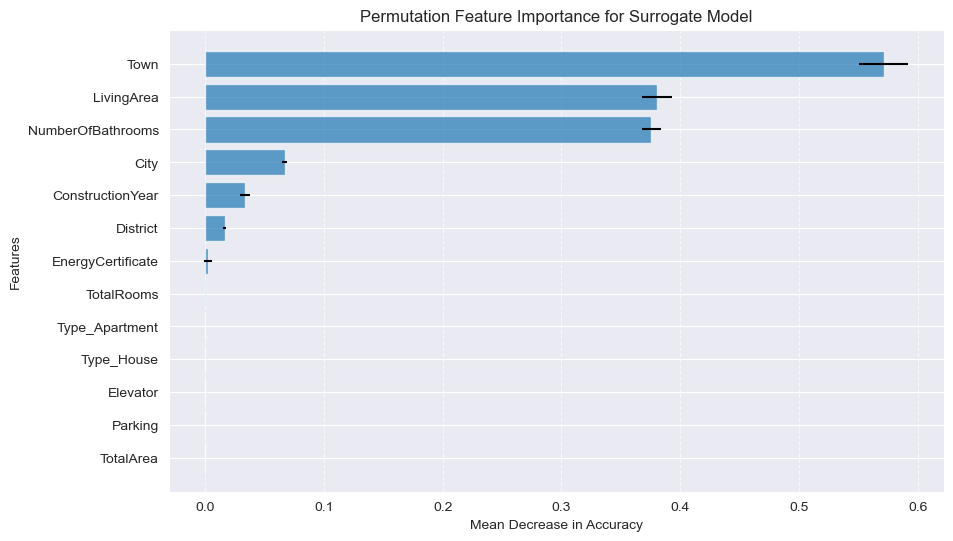

In [216]:
# Exibir resultados
print("\nPermutation Feature Importance for Surrogate Model:\n", pfi_df)

# Passo 4: Visualizar a Importância das Features
plt.figure(figsize=(10, 6))
plt.barh(pfi_df["Feature"], pfi_df["Mean Importance"], xerr=pfi_df["Std Dev"], align='center', alpha=0.7)
plt.xlabel("Mean Decrease in Accuracy")
plt.ylabel("Features")
plt.title("Permutation Feature Importance for Surrogate Model")
plt.gca().invert_yaxis()  # Inverter eixo Y para colocar as features mais importantes no topo
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

###### **Feature Importance Comparison**

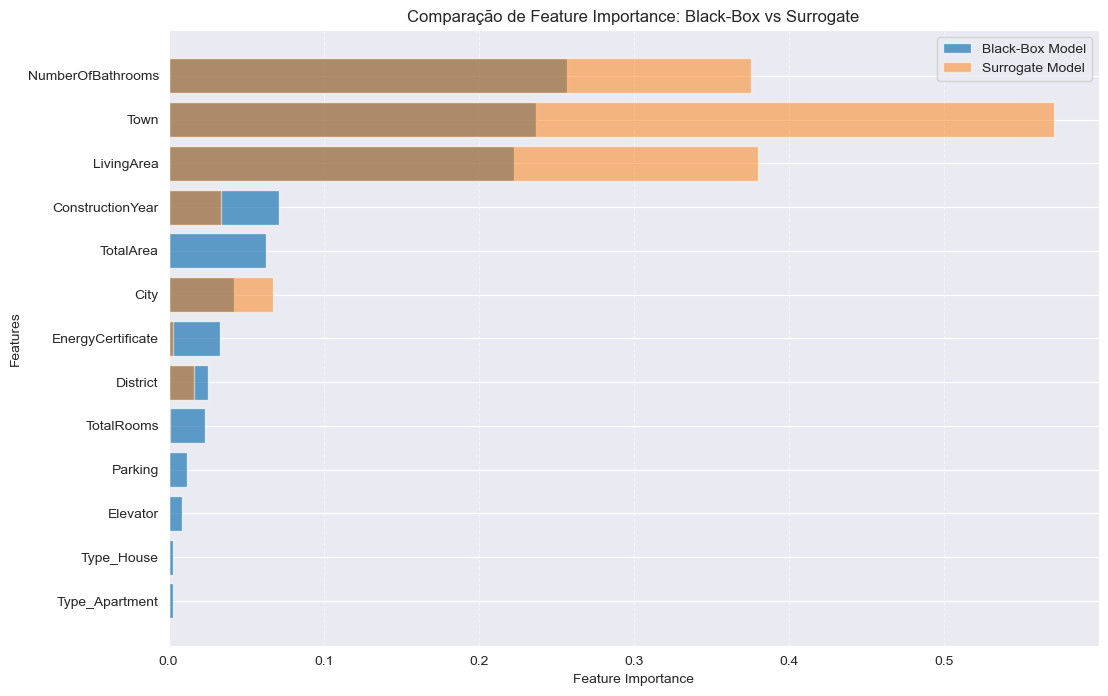

In [217]:
# Comparação entre Feature Importance do Black-Box e do Surrogate
plt.figure(figsize=(12, 8))

# Importância do Modelo Black-Box
plt.barh(blackbox_importance["Feature"], blackbox_importance["Importance"], alpha=0.7, label="Black-Box Model")

# Importância do Modelo Surrogate (Permutation)
plt.barh(pfi_df["Feature"], pfi_df["Mean Importance"], alpha=0.5, label="Surrogate Model")

plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Comparação de Feature Importance: Black-Box vs Surrogate")
plt.legend()
plt.gca().invert_yaxis()  # Inverter eixo Y para alinhar as features
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


The **surrogate model** captured the main features that dominate the predictions of the black-box model:
- **NumberOfBathrooms**
- **Town**
- **LivingArea**

This validates that the surrogate **approximates well the global behavior of the original model**.

However, the **surrogate model** is ignoring some less important variables, which still have an impact on the black-box model, such as:
- **TotalArea**
- **EnergyCertificate**

This indicates that the surrogate is **simpler and misses some complex interactions**.



### **Feature-Based Techniques** <a class="anchor" id="section_3_2"></a>

#### Sensitivity Analysis

##### Partial Dependence Plots (PDPs)
###### 1-way and 2-way Partial Dependence Plots (PDPs)

Interaction between 'Town' and 'LivingArea'

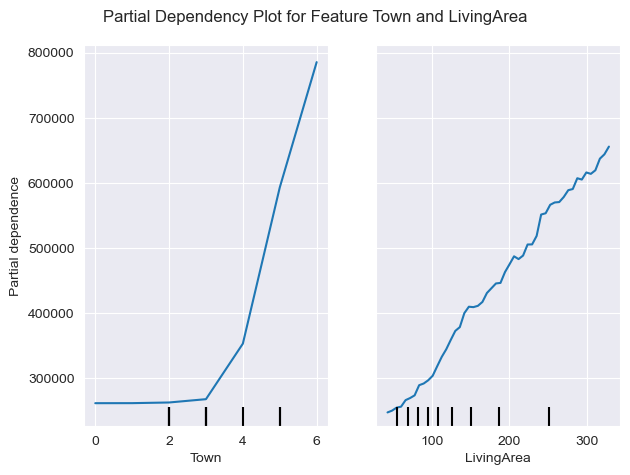

In [218]:
selected_features = [3, 11]  

# Partial dependency graph (PDP) for each individual element
PartialDependenceDisplay.from_estimator(
    black_model,
    X_train,
    selected_features,  
    feature_names=feature_names,
    grid_resolution=50,
)

# Display the plot
plt.suptitle("Partial Dependency Plot for Feature Town and LivingArea")
plt.tight_layout()
plt.show()

Town:
- Properties located in cities or areas with higher Town values have significantly higher prices.
- Town acts as a key location indicator.

LivingArea:
- LivingArea is a feature with a direct and constant impact: larger houses have higher price forecasts, as expected.

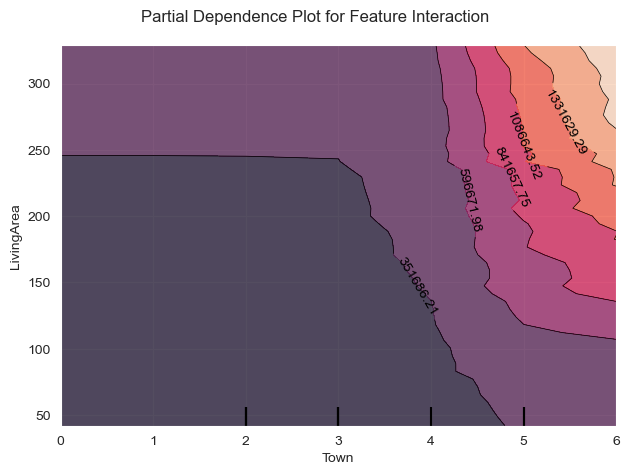

In [219]:
selected_features = [(3, 11)]  

PartialDependenceDisplay.from_estimator(
    black_model,
    X_train,
    selected_features,  # Interaction between Town and LivingArea
    feature_names=feature_names,
    grid_resolution=50,
)

# Display the plot
plt.suptitle("Partial Dependence Plot for Feature Interaction")
plt.tight_layout()
plt.show()

Interaction between Town and LivingArea:
- In regions where Town is low (≤ 3), even a large LivingArea does not raise forecasts significantly.
- This indicates that location (Town) plays a crucial role and can limit the impact of other variables.

Interaction between 'City' and 'TotalArea'

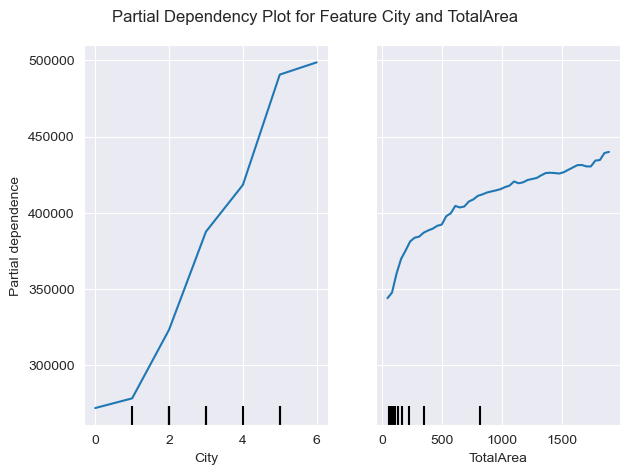

In [220]:
selected_features = [2, 9]  

# Partial dependency graph (PDP) for each individual element
PartialDependenceDisplay.from_estimator(
    black_model,
    X_train,
    selected_features,  
    feature_names=feature_names,
    grid_resolution=50,
)

# Display the plot
plt.suptitle("Partial Dependency Plot for Feature City and TotalArea")
plt.tight_layout()
plt.show()

City:
- City has a significant impact on high values, suggesting that areas with higher City values are associated with higher prices.
- City may be correlated with more valued or urbanized regions.

TotalArea:
- TotalArea has a direct and positive relationship with price: larger areas tend to have higher prices.
- The growth effect diminishes at very high values, indicating a diminishing return.

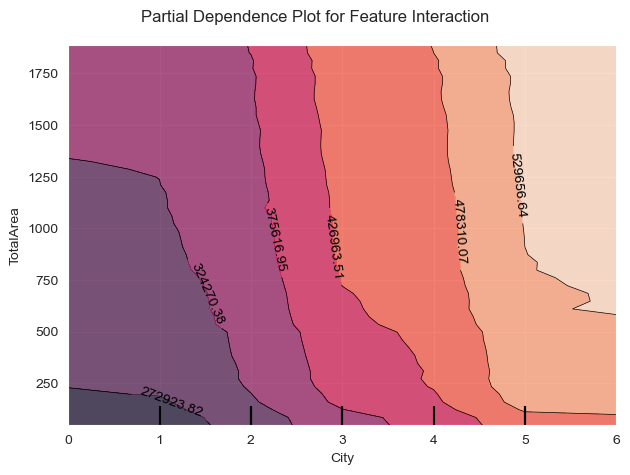

In [221]:
selected_features = [(2, 9)]  

PartialDependenceDisplay.from_estimator(
    black_model,
    X_train,
    selected_features,  # Interaction between City and TotalArea
    feature_names=feature_names,
    grid_resolution=50,
)

# Display the plot
plt.suptitle("Partial Dependence Plot for Feature Interaction")
plt.tight_layout()
plt.show()

Interaction between City and TotalArea:
- City dominates the impact: At low City values (≤ 2), even with high TotalArea, the price does not increase significantly.
- For high City values (> 4), the impact of TotalArea becomes more relevant, significantly increasing the price.

#### Feature Importance

##### Permutation Feature Importance


Permutation Feature Importance:
               Feature  Mean Importance   Std Dev
11         LivingArea         0.429762  0.006687
3                Town         0.363390  0.014836
12  NumberOfBathrooms         0.199530  0.010156
2                City         0.084602  0.004849
8    ConstructionYear         0.078861  0.005382
1            District         0.073282  0.006000
9           TotalArea         0.043407  0.004600
0   EnergyCertificate         0.027904  0.002924
10         TotalRooms         0.013445  0.001230
6            Elevator         0.009689  0.002592
5          Type_House         0.002683  0.000473
7             Parking         0.002225  0.000953
4      Type_Apartment         0.002107  0.000498


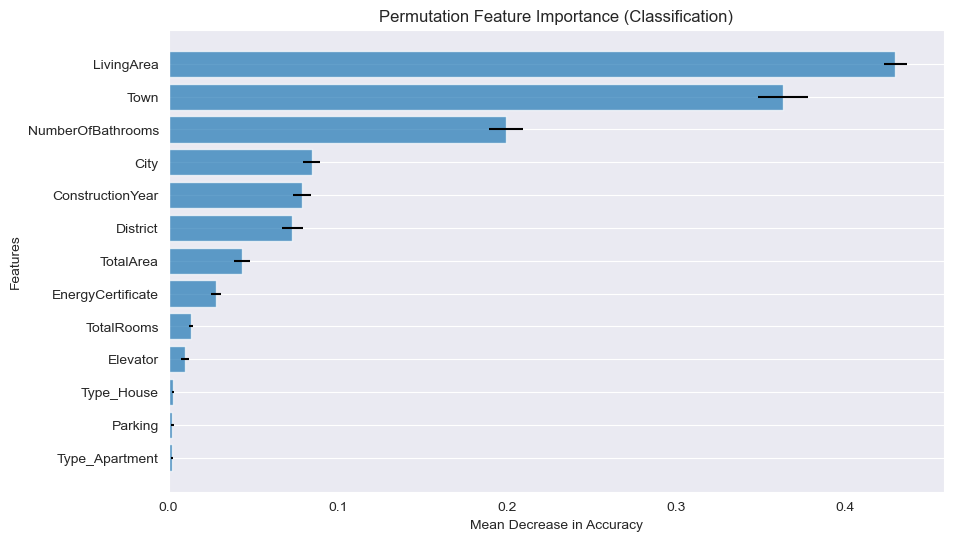

In [222]:
# Compute Permutation Feature Importance
# Permute features on the test set to assess their importance
pfi_results = permutation_importance(black_model, X_test, y_test, n_repeats=10, random_state=42)

# Organize results into a DataFrame
pfi_df = pd.DataFrame({
    "Feature": feature_names,
    "Mean Importance": pfi_results.importances_mean,
    "Std Dev": pfi_results.importances_std
}).sort_values(by="Mean Importance", ascending=False)

# Display feature importance
print("\nPermutation Feature Importance:\n", pfi_df)

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(pfi_df["Feature"], pfi_df["Mean Importance"], xerr=pfi_df["Std Dev"], align='center', alpha=0.7)
plt.xlabel("Mean Decrease in Accuracy")
plt.ylabel("Features")
plt.title("Permutation Feature Importance (Classification)")
plt.gca().invert_yaxis()
plt.grid(axis="x")
plt.show()

Main Features
- The LivingArea and Town variables are the main determinants in the model, with floor area standing out as the most relevant feature.
- Location (Town, City, District) and physical characteristics (LivingArea, NumberOfBathrooms) are the main decision factors.

Model validation:
- The model is prioritizing variables that are consistent with the logic of real estate prices:
    - Larger properties (LivingArea) and better located properties (Town, City) have a greater influence on predictions.

Secondary and Less Relevant Features:
- Variables such as Parking, Elevator, and housing types (house/apartment) have a very low impact, suggesting that:
    - The model does not consider these variables determinants for differentiating prices or classes.

##### Local Interpretable Model-Agnostic Explanations (LIME)

In [223]:
# LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,  
    feature_names=X_train.columns.values.tolist(),
    mode='regression',  # Regression Mode
    verbose=True,
    discretize_continuous=True 
)

In [224]:
# Instance for explanation
instance_index = 50
instance = X_test.iloc[instance_index]

In [225]:
features = X.columns

In [226]:
# Wrapper function to count model calls
def count_model_calls(input_data):
    global model_calls
    model_calls += input_data.shape[0]
    return black_model.predict(input_data)

In [227]:
model_calls = 0

In [228]:
# Generate the LIME explanation for the selected instance
exp = explainer.explain_instance(instance.values, count_model_calls, num_features=len(features))

print(exp.as_list())

Intercept 485680.1024111608
Prediction_local [482267.05142433]
Right: 555437.3055853917
[('2.00 < Town <= 3.00', -134631.15942812257), ('ConstructionYear > 2009.00', 98007.91215126429), ('EnergyCertificate > 5.00', 82255.96533866531), ('3.00 < TotalRooms <= 4.00', -63053.49405770688), ('108.00 < LivingArea <= 165.00', -60636.476843718665), ('2.00 < City <= 3.00', 51936.061497706774), ('86.00 < TotalArea <= 133.00', -47718.958533708224), ('Type_House <= 0.00', 25541.07712517947), ('2.00 < NumberOfBathrooms <= 3.00', 23210.17267671698), ('0.00 < Type_Apartment <= 1.00', 17108.919890701727), ('0.00 < Elevator <= 1.00', 11137.286584668662), ('0.00 < Parking <= 1.00', -9292.63896709764), ('2.00 < District <= 3.00', 2722.281578620572)]


In [229]:
exp.show_in_notebook()

**LIME Evaluation of Instance 50**

Main Positive Factors:
- Year of construction (2024): Newer properties are associated with higher values.
- High Energy Certificate (9.00): Energy efficiency has an important positive impact.
- Number of Bathrooms and City: Specific values increase the prediction.

Negative Factors:
- Town between 2.00 and 3.00: Reduces the prediction, suggesting that the location has limited potential.
- Relatively Small Areas (TotalArea and LivingArea = 128): Although these are negative contributions, they do not cancel out the positive impact of other variables.

Points of Interest:
- The final prediction (462.282.02) is the result of the balance between the positive and negative effects.
- The impact of ConstructionYear and EnergyCertificate is much more significant than the negative contributions of Town and small areas.
- Variables such as Parking, Elevator and Type_House have minimal influence.

##### SHapley Additive exPlanations (SHAP)

In [230]:
# Start Time
start_time = time.time()

explainer = shap.TreeExplainer(black_model)
shap_values = explainer.shap_values(X_test)

# End Time
end_time = time.time()

In [231]:
print(shap_values.shape)

(9738, 13)


In [232]:
print(shap_values[10,:])

[ 8.10578350e+04  1.08466862e+05  1.21531057e+05  8.84978081e+05
  2.15467155e+04  9.90831272e+03  7.64858536e+04  6.85705708e+04
  4.74813405e+05  6.45945214e+02  6.20586287e+03  6.38111343e+05
 -8.08621339e+03]


In [233]:
# Instance to explain
instance_index = 50
instance = X_test.iloc[instance_index]
print(instance)

EnergyCertificate       9.0
District                3.0
City                    3.0
Town                    3.0
Type_Apartment          1.0
Type_House              0.0
Elevator                1.0
Parking                 1.0
ConstructionYear     2024.0
TotalArea             128.0
TotalRooms              4.0
LivingArea            128.0
NumberOfBathrooms       3.0
Name: 45447, dtype: float64


In [234]:
features = X.columns

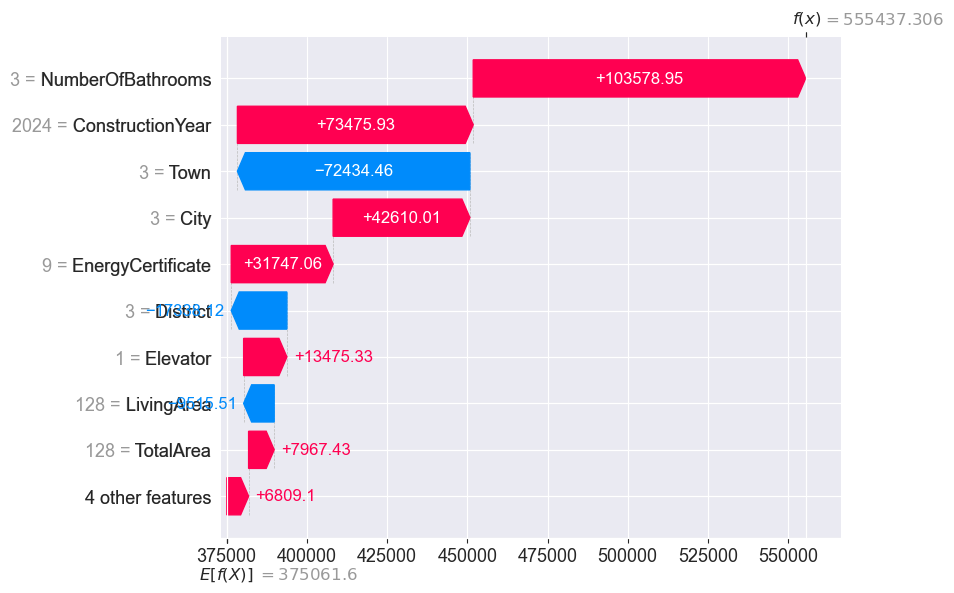

In [235]:
# Create a waterfall plot for the selected instance
shap.waterfall_plot(
    shap.Explanation(
       values=shap_values[instance_index,:],  
       base_values=explainer.expected_value,  
       data=instance.values, 
       feature_names=features  
   )
)

**SHAP Evaluation of Instance 50**

Positive Factors:
- NumberOfBathrooms and ConstructionYear have the largest positive contributions.
- This suggests that properties with more bathrooms and recent construction are the main factors driving up the predicted value.

Main Negative Factor:
- Town = 3 significantly reduces the predicted value, indicating that this location is not as highly valued.

Secondary Factors:
- EnergyCertificate and City also play important roles in increasing predicted value, suggesting that energy efficiency features and location (city) have moderate influence.

Total Impact:
- The final prediction (555.437) is explained by the combination of the positive drivers (bathrooms, recent construction) and the negative driver (Town).

In [236]:
print(shap_values[:,1])

[  1219.95092701 -28299.55868842 -26946.47258831 ...  -5299.64069788
  27590.60244633 -46141.38152512]


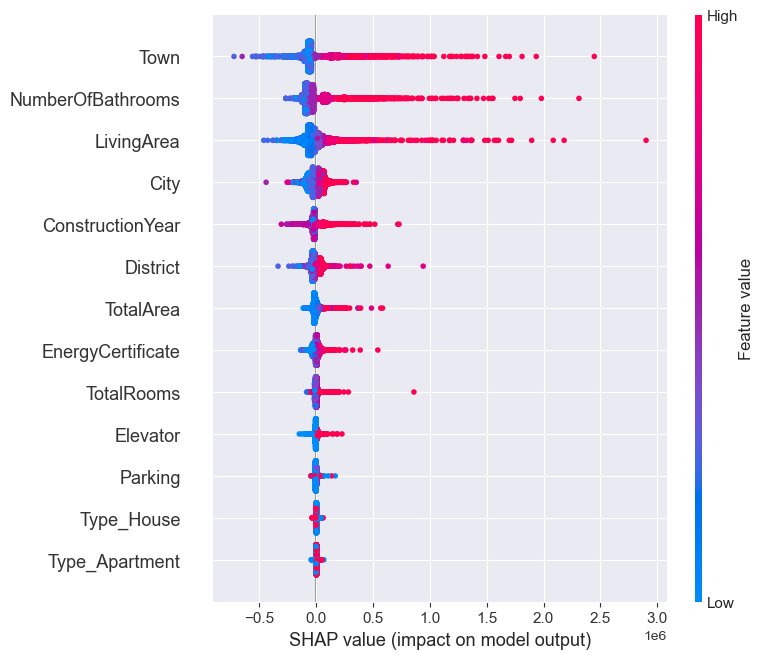

In [237]:
# Generate a beeswarm plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=features)

**SHAP Global Value Analysis**

Key Findings
- Town, NumberOfBathrooms, and LivingArea are the main drivers in the model:
    - Location (Town) and physical characteristics (bathrooms and floor area) have the biggest impact on price.
- High values of Town, NumberOfBathrooms, and LivingArea tend to increase the price, while low values have a negative impact.
- ConstructionYear and EnergyCertificate also play a role, especially when the values are high.
- Less influential variables (Parking, Elevator) still contribute, but not critically to the model.

 ### **Example-Based Technique** <a class="anchor" id="section_3_3"></a>

#### **Counterfactuals**

We use DiCE to generate counterfactuals for any our black-box model by finding the closest points in the dataset that give the output as the desired range.

In [ ]:
import dice_ml
from dice_ml import Dice

In [ ]:
target = df['Price']
feature_names = df.drop('Price', axis=1).columns.tolist()

In [ ]:
datasetX = df.drop('Price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(datasetX,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0)

regr = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

model = regr.fit(X_train, y_train)

In [ ]:
numerical_columns2 = datasetX.select_dtypes(include=['number']).columns.tolist()

In [ ]:
d = dice_ml.Data(dataframe=df, continuous_features=numerical_columns2, outcome_name='Price')
m = dice_ml.Model(model=model, backend="sklearn", model_type='regressor')

In [ ]:
exp = Dice(d, m, method="kdtree")

In [ ]:
def contrafactuals(query_instances, total_cfs, range):
    explanations = exp.generate_counterfactuals(query_instances,total_CFs=total_cfs,desired_range=range)
    explanations.visualize_as_dataframe(show_only_changes=True)

**a) Price Range [50000, 150000]**

In [ ]:
contrafactuals(X_test.sample(1), 3, [50000, 150000])

100%|██████████| 1/1 [00:02<00:00,  2.58s/it]

Query instance (original outcome : 418458.90625)


,District,City,Town,Type,EnergyCertificate,Parking,ConstructionYear,TotalArea,Elevator,TotalRooms,LivingArea,NumberOfBathrooms,Price
0,Lower-Mid Price,Low Price,Mid Price,House,B-,1.0,2011.0,780.0,True,3.0,218.0,4.0,418458.90625



Diverse Counterfactual set (new outcome: [50000, 150000])


,District,City,Town,Type,EnergyCertificate,Parking,ConstructionYear,TotalArea,Elevator,TotalRooms,LivingArea,NumberOfBathrooms,Price
14203,-,-,Lower-Mid Price,-,F,0.0,-,-,-,-,186.0,0.0,-
7133,-,-,Lower-Mid Price,-,NC,3.0,-,-,-,-,178.0,1.0,-
6170,-,-,-,-,F,0.0,-,-,-,-,245.0,2.0,-


**How features change so the price fits the defined range (so the price lowers)?**
- Town adjusted to a slightly lower price category;
- Energy Certificate significantly downgraded across counterfactuals;
- Parking reduced in two counterfactuals, which aligns with the goal of lowering the price. In one counterfactual, Parking increases from 1.0 to 3.0;
- NumberofBathrooms consistently reduced in all counterfactuals;
- LivingArea is incosistent.

**a) Price Range [200000, 299999]**

In [ ]:
contrafactuals(X_test.sample(1), 5, [200000, 299999])

100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

Query instance (original outcome : 480701.34375)


,District,City,Town,Type,EnergyCertificate,Parking,ConstructionYear,TotalArea,Elevator,TotalRooms,LivingArea,NumberOfBathrooms,Price
0,Mid Price,Mid Price,Mid Price,House,B,3.0,2023.0,417.0,True,3.0,195.0,2.0,480701.34375



Diverse Counterfactual set (new outcome: [200000, 299999])


,District,City,Town,Type,EnergyCertificate,Parking,ConstructionYear,TotalArea,Elevator,TotalRooms,LivingArea,NumberOfBathrooms,Price
2586,Lower-Mid Price,Low Price,-,-,C,1.0,-,-,-,-,206.0,-,-
6616,Lower-Mid Price,-,-,-,C,2.0,-,-,-,5.0,176.0,-,-
7035,Lower-Mid Price,Lower-Mid Price,-,-,D,-,-,-,-,4.0,184.0,3.0,-
32970,Lower-Mid Price,Lower-Mid Price,Lower-Mid Price,-,E,2.0,-,-,-,4.0,176.0,-,-
2516,Lower-Mid Price,Lower-Mid Price,Lower-Mid Price,-,C,-,-,-,-,-,170.0,-,-


**How features change so the price fits the defined range (so the price lowers)?**

- District consistently changes to a lower-price district category;
- Generally City and Town are adjusted to lower-priced regions;
- Counterfactuals reduce the **EnergyCertificate** level (e.g., from C to D or lower). This may reflects that a worse energy efficiency certificate correlates with a lower price;
- Parking is reduced;
- LivingArea generally decreased, showing that larger areas increase price;
- TotalRooms increases, which doesn't seem to make much sense;
- NumberOfBathrooms reduces.

In [ ]:
contrafactuals(X_test.sample(1), 3, [200000, 299999])

100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

Query instance (original outcome : 61121.0)


,District,City,Town,Type,EnergyCertificate,Parking,ConstructionYear,TotalArea,Elevator,TotalRooms,LivingArea,NumberOfBathrooms,Price
0,Low Price,Very Low Price,Lower-Mid Price,House,F,0.0,1937.0,70.0,True,2.0,135.0,1.0,61121.0



Diverse Counterfactual set (new outcome: [200000, 299999])


,District,City,Town,Type,EnergyCertificate,Parking,ConstructionYear,TotalArea,Elevator,TotalRooms,LivingArea,NumberOfBathrooms,Price
30421,High Price,Mid Price,-,-,E,-,-,77.0,-,-,107.0,3.0,-
17335,High Price,Upper-Mid Price,Mid Price,-,E,-,-,55.0,-,-,112.0,2.0,-
44053,Mid Price,Low Price,Mid Price,-,E,-,-,72.0,-,5.0,160.0,2.0,-


**How features change so the price fits the defined range (so the price rises)?**
- The District is consistently adjusted to a higher price category;
- EnergyCertificate is upgraded by one category across all counterfactuals;
- NumberOfBathrooms is increased in all counterfactuals;
- TotalRooms also increses;
- The changes in LivingArea and TotalArea are inconsistent—sometimes increasing, sometimes decreasing;

**c) Price Range [500000, 599999]**

In [ ]:
contrafactuals(X_test.sample(1), 3, [500000, 599999])

100%|██████████| 1/1 [00:02<00:00,  2.62s/it]

Query instance (original outcome : 1168895.75)


,District,City,Town,Type,EnergyCertificate,Parking,ConstructionYear,TotalArea,Elevator,TotalRooms,LivingArea,NumberOfBathrooms,Price
0,Mid Price,Mid Price,High Price,House,B,0.0,2018.0,412.0,True,6.0,252.0,4.0,1168895.75



Diverse Counterfactual set (new outcome: [500000, 599999])


,District,City,Town,Type,EnergyCertificate,Parking,ConstructionYear,TotalArea,Elevator,TotalRooms,LivingArea,NumberOfBathrooms,Price
15199,-,-,-,-,B-,3.0,-,-,-,5.0,279.0,3.0,-
12645,-,-,-,-,D,2.0,-,-,-,4.0,-,0.0,-
18495,High Price,High Price,Mid Price,-,-,1.0,-,-,-,4.0,233.0,3.0,-


**How features change so the price fits the defined range (so the price lowers)?**
- In two counterfactuals, location features remain unchanged, which contrasts with previous generated counterfactuals; In the third counterfactual, District and City increase to higher price categories, while Town moves to a lower price range, showing mixed behavior.
- Energy Certificate is reduced to a lower range in two counterfactuals;
- Parking is increased in all counterfactuals, which is unexpected given that reducing Parking typically aligns with lowering the price.
- TotalRooms consistently decreased in all counterfactuals;
- LivingArea shows inconsistent behavior, going up in some counterfactuals and down in others;
- Number of Bathrooms reduced across all counterfactuals;

The inconsistent behavior may be related to the outlier nature of the instance.

## **4. Quality of Explanations**

#### Fidelity

In [238]:
mae = mean_absolute_error(y_test, y_pred_rf)
print("Erro Absoluto Médio (MAE):", mae)

mse = mean_squared_error(y_test, y_pred_rf)
print("Erro Quadrático Médio (MSE):", mse)

r2 = r2_score(y_test, y_pred_rf)
print("R2 Score:", r2)

Erro Absoluto Médio (MAE): 93260.90905434213
Erro Quadrático Médio (MSE): 52911417948.00075
R2 Score: 0.7968227345939741


MAE: 
- On average, the model gets approximately 93,260 euros wrong when making its predictions.

R² Score:
- The model explains around 79.68% of the variance in the actual values. This indicates that the model is reasonably good, but still has room for improvement.

#### Comprehensibility / Simplicity

In [239]:
# Average depth of trees
tree_depths = [estimator.tree_.max_depth for estimator in black_model.estimators_]
avg_tree_depth = sum(tree_depths) / len(tree_depths)

print(f"Profundidade média das árvores: {avg_tree_depth}")

Profundidade média das árvores: 15.0


- The depth of a decision tree indicates how many levels of splits are needed to arrive at a prediction.
- A greater depth means more complex trees, with more detailed and specific rules.

A **Depth of 15** is relatively high, indicating that the **trees are complex and have many decision levels**.

In [240]:
# Average number of nodes
num_nodes = [estimator.tree_.node_count for estimator in black_model.estimators_]
avg_num_nodes = sum(num_nodes) / len(num_nodes)

print(f"Número médio de nós por árvore: {avg_num_nodes}")

Número médio de nós por árvore: 11263.38


- A node in a decision tree represents a split (division based on a feature).
- Trees with more nodes are more complex and can be difficult to interpret.

The high average number of nodes, **11263.38**, suggests that the model has **learned very specific patterns and may be capturing too many interactions or complexities in the data**.

#### Computational Cost 

In [241]:
# Calculation of total time
execution_time = end_time - start_time
print(f"Tempo de execução para gerar as explicações: {execution_time:.2f} segundos")

Tempo de execução para gerar as explicações: 1204.55 segundos


Execution time to generate the explanations: 1204.55 seconds (~20 minutes)

In [242]:
# Number of model calls
print(f"Número de chamadas ao modelo: {model_calls}")

Número de chamadas ao modelo: 5000


The model was called up 5000 times during the explanation process

#### Stability

###### Searching for an adjusted noise level

In [243]:
important_features = [(X_train.columns[i], importance) for i, importance in enumerate(feature_importances)]
important_features = dict(important_features)  
important_features

{'EnergyCertificate': 0.03807512988613977,
 'District': 0.0421931605597715,
 'City': 0.037555782764454905,
 'Town': 0.2389974300982332,
 'Type_Apartment': 0.002640567142457934,
 'Type_House': 0.0030868496561698815,
 'Elevator': 0.005864459250742144,
 'Parking': 0.008678798523199886,
 'ConstructionYear': 0.06135149203754894,
 'TotalArea': 0.0656138579416519,
 'TotalRooms': 0.028809532844351983,
 'LivingArea': 0.2296793141812083,
 'NumberOfBathrooms': 0.23745362511406956}

In [244]:
feature_std = X_train.std().to_dict()
feature_std

{'EnergyCertificate': 2.52030216625252,
 'District': 1.4427539005662773,
 'City': 1.5043427173621449,
 'Town': 1.3645129013005775,
 'Type_Apartment': 0.4995322377287408,
 'Type_House': 0.4995322377287408,
 'Elevator': 0.46746819502878384,
 'Parking': 0.9795375646421962,
 'ConstructionYear': 26.324567904654042,
 'TotalArea': 476398.52894419647,
 'TotalRooms': 14.05699874126495,
 'LivingArea': 4783.5174627029755,
 'NumberOfBathrooms': 1.3704615394478226}

In [245]:
# Initial setup
base_noise_level = 0.01

# Calculate adjusted noise
features = feature_std.keys()
std_sum = sum(feature_std.values())
importance_sum = sum(important_features.values())

adjusted_noise = {
    feature: base_noise_level
    * (important_features[feature] / importance_sum)
    * (feature_std[feature] / std_sum)
    for feature in features
}

# Adjusted global noise level (weighted average of importance-adjusted noise)
global_noise = sum(adjusted_noise.values())
print(f"Nível de ruído global ajustado: {global_noise}")

Nível de ruído global ajustado: 0.0006724375566981949


###### We set the noise level to 0.0005

In [246]:
# Add Gaussian noise to features
noise_level = 0.0005  # Control the noise intensity
perturbed_X_test = X_test + np.random.normal(0, noise_level, X_test.shape)

In [247]:
# Generate explanations for the perturbed data
perturbed_shap_values = explainer.shap_values(perturbed_X_test)

In [248]:
# Calculate variance in explanations (average difference between original and perturbed explanations)
explanation_variance = np.mean([
    np.linalg.norm(shap_values[i] - perturbed_shap_values[i]) 
    for i in range(len(X_test))
])

print(f"Variância média nas explicações devido a perturbações: {explanation_variance}")

Variância média nas explicações devido a perturbações: 1715.8472167011357


The highest concentration of prices is between €100,000 and €316,000.

Variance value - 1715.85:
- The variance of the explanations is relatively small compared to the property prices.
- This suggests that the model has good stability and that small perturbations in the data don't influence the explanations too much.


In [249]:
# Calculate LLE (maximum ratio between explanations and instances)
lle_values = []
for i in range(len(X_test)):
    instance_distance = euclidean(X_test.iloc[i], perturbed_X_test.iloc[i])  # Distance between instances
    explanation_distance = np.linalg.norm(shap_values[i] - perturbed_shap_values[i])  # Distance between explanations
    lle_values.append(explanation_distance / (instance_distance + 1e-8))  # Avoid division by zero

average_lle = np.mean(lle_values)  # Medium LLE
print(f"Local Lipschitz Estimate (LLE) médio: {average_lle}")

Local Lipschitz Estimate (LLE) médio: 1021169.8682300494


Value: 1 021 169.86:
- The LLE is the maximum of the ratio between the differences in explanations and the differences in instances.
- A high LLE value indicates that, locally, there are sensitive areas in the model where small changes in the input data result in large variations in the SHAP values.

**Global Stability:** The variance of the explanations (1715.85) is low when averaged. This indicates that the model is globally stable.

**Local Sensitivity:** The high LLE (1 021 169.86) suggests that there are specific local regions where the explanations vary greatly with small changes in the data.